In [11]:
# Notebook header

import os, json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from monty.json import MontyDecoder

from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.core import Orbital, OrbitalType
from pymatgen.electronic_structure.dos import Dos, CompleteDos
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen import Element, Spin

from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d

data_dir = "../substitutions/oxy_oxidation/data/"
figures_dir = "../../../figures/batteries"

with open(os.path.join(data_dir, "pdos_data.json"), "r") as file:
    pdos_data = json.loads(file.read())
    
def smear(e, d, sigma=0.05):
    diff = [e[i + 1] - e[i] for i in range(len(e) - 1)]
    avgdiff = sum(diff) / len(diff)
    return gaussian_filter1d(d, sigma / avgdiff)

def add_spd_dos_to_axis(axis, cdos, el_dict, smearing=0.02):
    
    legend_items = []
    
    for element in el_dict.keys():
        for orbital in el_dict[element].keys():
            
            spd_dos = cdos.get_element_spd_dos(element)[el_dict[element][orbital]]
            spd_dos.energies -= spd_dos.efermi

            densities = smear(spd_dos.energies, spd_dos.get_densities(), smearing)
            interp_function = interp1d(spd_dos.energies, densities, kind="cubic")
            new_e = np.linspace(-5, 5, 10000)
            interp_densities = interp_function(new_e).clip(min=0)
    
            axis.plot(new_e, interp_densities)
            legend_items.append(element + " " + orbital)
    
    axis.legend(legend_items, loc='upper left', frameon=False)

# PDOS analysis

In this notebook I've set up some simple scripts for plotting the projected density of states.


### Substitutions

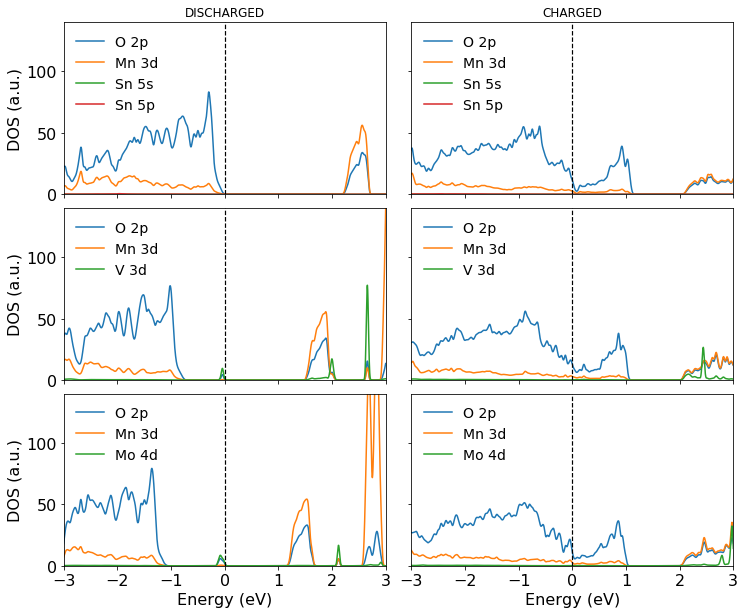

In [17]:
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True)

fig.set_size_inches(12, 10)
xlim = [-3, 3]
ylim = [0, 140]
functional = "pbeu"

el_dict = {"O": {"2p": OrbitalType.p},
           "Mn": {"3d": OrbitalType.d},
           "Sn": {"5s": OrbitalType.s, "5p": OrbitalType.p}}

cdos = CompleteDos.from_dict(pdos_data["Sn"]["discharged"][functional])
add_spd_dos_to_axis(ax[0][0], cdos, el_dict)
ax[0][0].plot([0, 0], [0, 140], "k--", linewidth=1.2)
ax[0][0].set_ylabel("DOS (a.u.)", fontdict={'size': 16})
ax[0][0].set_title("DISCHARGED")

cdos = CompleteDos.from_dict(pdos_data["Sn"]["charged"][functional])
add_spd_dos_to_axis(ax[0][1], cdos, el_dict)
ax[0][1].plot([0, 0], [0, 140], "k--", linewidth=1.2)
ax[0][1].set_title("CHARGED")

el_dict = {"O": {"2p": OrbitalType.p},
           "Mn": {"3d": OrbitalType.d},
           "V": {"3d": OrbitalType.d}}

cdos = CompleteDos.from_dict(pdos_data["V"]["discharged"][functional])
add_spd_dos_to_axis(ax[1][0], cdos, el_dict)
ax[1][0].plot([0, 0], [0, 140], "k--", linewidth=1.2)
ax[1][0].set_ylabel("DOS (a.u.)", fontdict={'size': 16})

cdos = CompleteDos.from_dict(pdos_data["V"]["charged"][functional])
add_spd_dos_to_axis(ax[1][1], cdos, el_dict)
ax[1][1].plot([0, 0], [0, 140], "k--", linewidth=1.2)

el_dict = {"O": {"2p": OrbitalType.p},
           "Mn": {"3d": OrbitalType.d},
           "Mo": {"4d": OrbitalType.d}}

cdos = CompleteDos.from_dict(pdos_data["Mo"]["discharged"][functional])
add_spd_dos_to_axis(ax[2][0], cdos, el_dict)
ax[2][0].plot([0, 0], [0, 140], "k--", linewidth=1.2)
ax[2][0].set_ylabel("DOS (a.u.)", fontdict={'size': 16})
ax[2][0].set_xlabel("Energy (eV)", fontdict={'size': 16})

cdos = CompleteDos.from_dict(pdos_data["Mo"]["charged"][functional])
add_spd_dos_to_axis(ax[2][1], cdos, el_dict)
ax[2][1].plot([0, 0], [0, 140], "k--", linewidth=1.2)
ax[2][1].set_xlabel("Energy (eV)", fontdict={'size': 16})

for axis in np.nditer(ax, flags=["refs_ok"]):
    axis.item().set_xlim(xlim)
    axis.item().set_ylim(ylim)

plt.subplots_adjust(wspace=0.08, hspace=0.08)
plt.savefig(os.path.join(figures_dir, "substitution_pdos_" + functional + ".png"), 
            dpi=300, bbox_inches="tight")

## NEB Barriers

In [14]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

from pybat.core import DimerNEBAnalysis
figures_dir = "/Users/mbercx/Dropbox/Phd/thesis/figures/batteries"

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

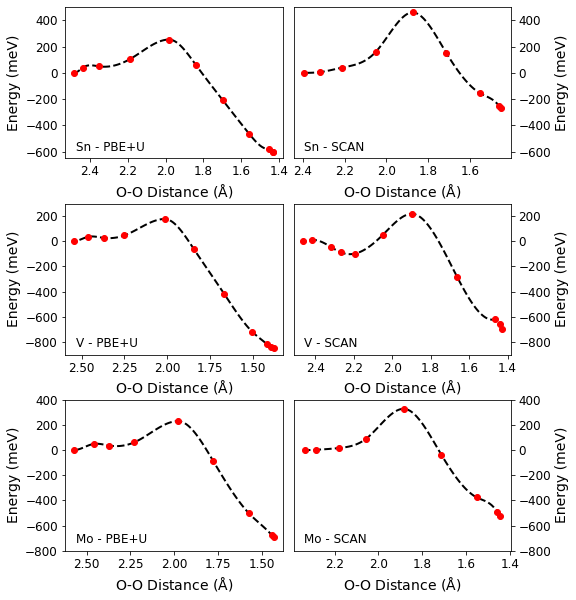

In [62]:
fig, ax = plt.subplots(3, 2)

fig.set_size_inches(8, 10)

neb = DimerNEBAnalysis.from_file("data/neb_Sn_pbeu.json")
neb.setup_interpolation({"spline": "zero_slope"})
neb.add_plot_to_axis(ax[0][0])
ax[0][0].set_ylim([-650, 500])
ax[0][0].text(0.05, 0.05, "Sn - PBE+U", 
              transform=ax[0][0].transAxes)

neb = DimerNEBAnalysis.from_file("data/neb_Sn_scan.json")
neb.setup_interpolation({"spline": "zero_slope"})
neb.add_plot_to_axis(ax[0][1])
ax[0][1].set_ylim([-650, 500])
ax[0][1].yaxis.tick_right()
ax[0][1].yaxis.set_label_position("right")
ax[0][1].text(0.05, 0.05, "Sn - SCAN", 
              transform=ax[0][1].transAxes)

neb = DimerNEBAnalysis.from_file("data/neb_V_pbeu.json")
neb.setup_interpolation({"spline": "zero_slope"})
neb.add_plot_to_axis(ax[1][0])
ax[1][0].set_ylim([-900, 300])
ax[1][0].text(0.05, 0.05, "V - PBE+U", 
              transform=ax[1][0].transAxes)

neb = DimerNEBAnalysis.from_file("data/neb_V_scan.json")
neb.setup_interpolation({"spline": "zero_slope"})
neb.add_plot_to_axis(ax[1][1])
ax[1][1].set_ylim([-900, 300])
ax[1][1].yaxis.tick_right()
ax[1][1].yaxis.set_label_position("right")
ax[1][1].text(0.05, 0.05, "V - SCAN", 
              transform=ax[1][1].transAxes)

neb = DimerNEBAnalysis.from_file("data/neb_Mo_pbeu.json")
neb.setup_interpolation({"spline": "zero_slope"})
neb.add_plot_to_axis(ax[2][0])
ax[2][0].set_ylim([-800, 400])
ax[2][0].text(0.05, 0.05, "Mo - PBE+U", 
              transform=ax[2][0].transAxes)

neb = DimerNEBAnalysis.from_file("data/neb_Mo_scan.json")
neb.setup_interpolation({"spline": "zero_slope"})
neb.add_plot_to_axis(ax[2][1])
ax[2][1].set_ylim([-800, 400])
ax[2][1].yaxis.tick_right()
ax[2][1].yaxis.set_label_position("right")
ax[2][1].text(0.05, 0.05, "Mo - SCAN", 
              transform=ax[2][1].transAxes)

plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.savefig(os.path.join(figures_dir, "substitution_dimers.png"), dpi=300)